In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-darkgrid")

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# オッカムの剃刀（Occam's razor）　- 単純さと精度

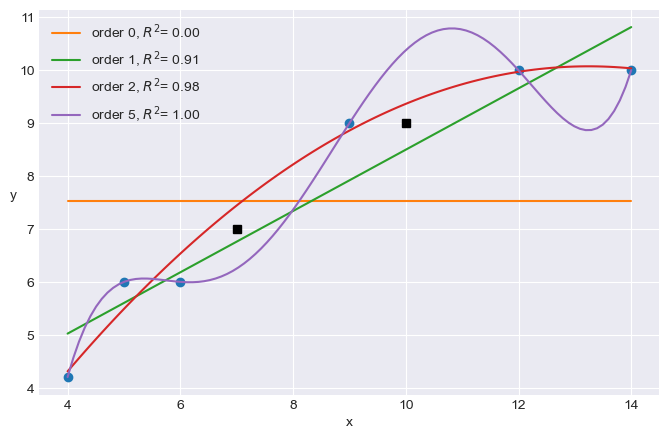

In [2]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

plt.figure(figsize=(8, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)

    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_05_05.png', dpi=300)
plt.plot([10, 7], [9, 7], 'ks')
plt.savefig('img601.png', dpi=300)

## 6.3.3 PyMC3による情報量規準の計算
- 簡単な例で使用法を確認する
    * 線形回帰と２次の多項式フィッティングによる比較

x_1.shape=(20,), y_1.shape=(20,)
order=2
x_1s.shape=(2, 20)
x_1p.shape=(2, 20)


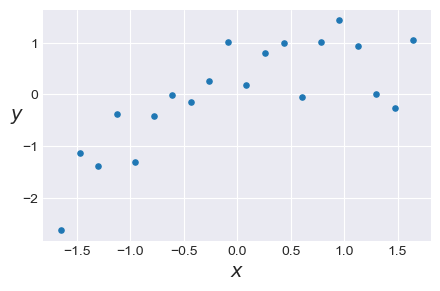

In [3]:
real_alpha = 4.254
real_beta = [8.7, -1.2]
data_size = 20
noise = np.random.normal(0, 2, size=data_size)
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1 **2 + noise

order = 2 # 5
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

print(f"{x_1.shape=}, {y_1.shape=}")
print(f"{order=}")

print(f"{x_1s.shape=}")
print(f"{x_1p.shape=}")

plt.figure(figsize=(5,3))
plt.scatter(x_1s[0], y_1s, s=14)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14, rotation=0)
plt.savefig("img604.png")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No m

Sampling 4 chains for 1_000 tune and 2_100 draw iterations (4_000 + 8_400 draws total) took 8 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


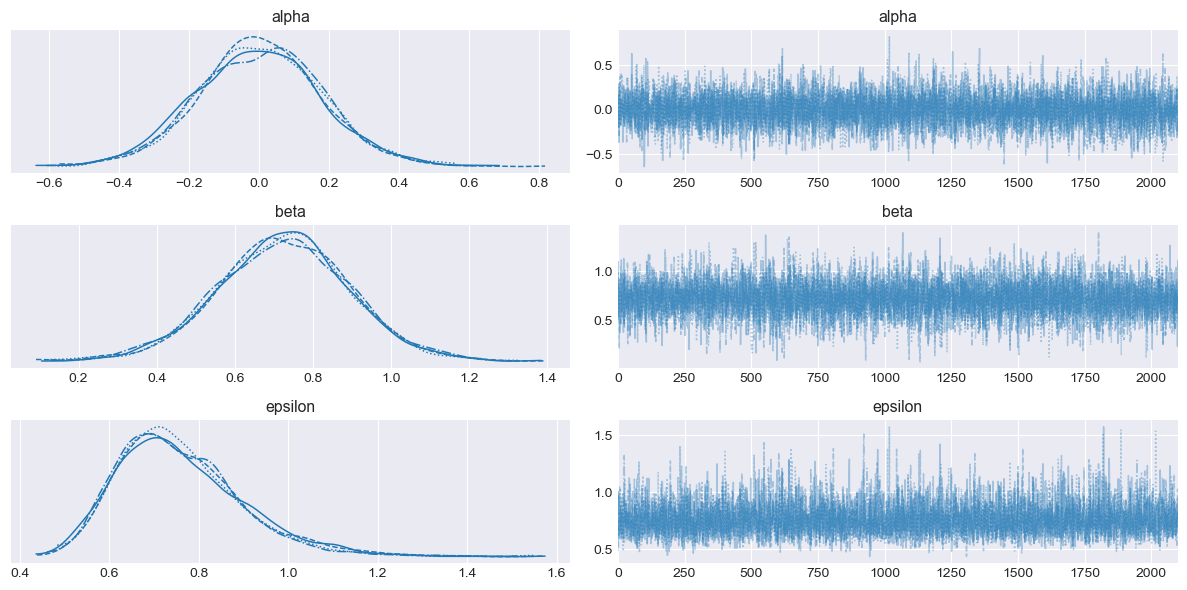

In [4]:
# 線形単回帰
with pm.Model() as model_l:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    epsilon = pm.HalfCauchy("epsilon", beta=5)
    
    mu = alpha + beta * x_1s[0]
    y_pred = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y_1s)

    trace_l = pm.sample(2100, return_inferencedata=False)

az.plot_trace(trace_l)
plt.tight_layout()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No m

Sampling 4 chains for 1_000 tune and 2_100 draw iterations (4_000 + 8_400 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8852533768988156, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


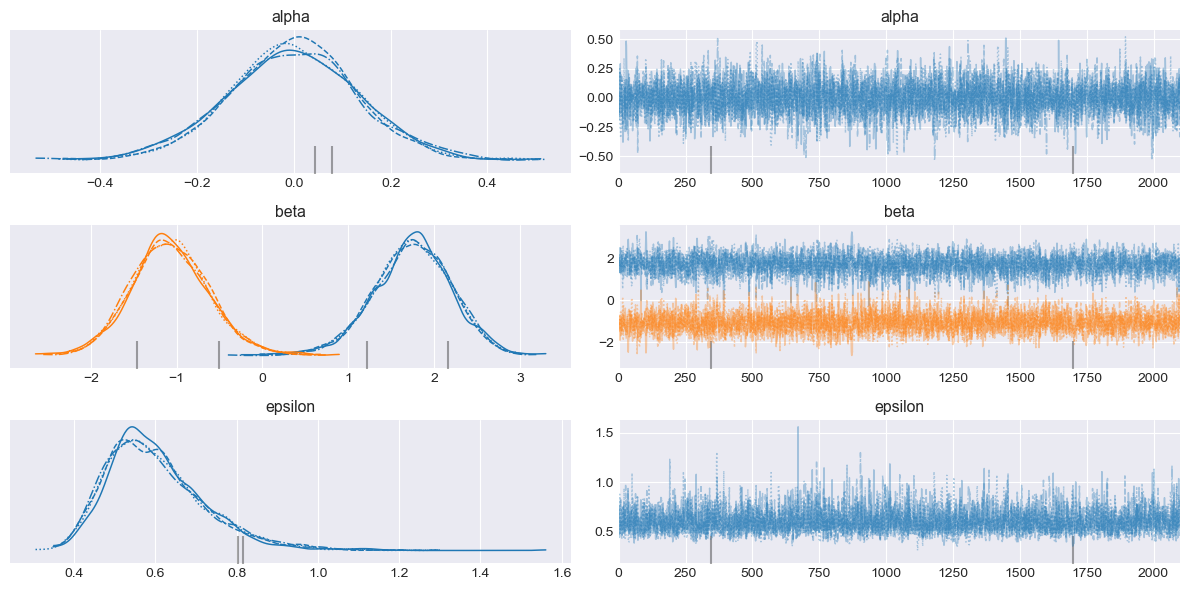

In [5]:
# ２次の多項式
with pm.Model() as model_p:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=x_1s.shape[0])
    epsilon = pm.HalfCauchy("epsilon", beta=5)

    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y_1s)

    trace_p = pm.sample(2100, return_inferencedata=False)

az.plot_trace(trace_p)
plt.tight_layout()

In [6]:
chain_l = trace_l[100:]

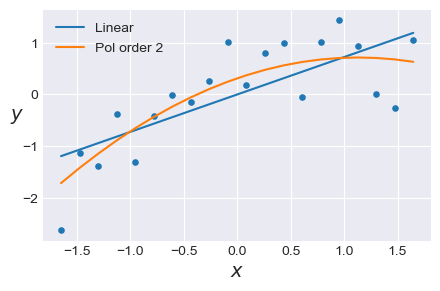

In [7]:
# trace_l, trace_pの情報を使ってフィッティングの様子を示す。
alpha_l_post = trace_l["alpha"].mean()
alpha_p_post = trace_p["alpha"].mean()
betas_l_post = trace_l["beta"].mean(axis=0)
betas_p_post = trace_p["beta"].mean(axis=0)

idx = np.argsort(x_1s[0])  # idxいるか？いらないのでは。。少なくともプロットに入らない気がするが。
y_l_post = alpha_l_post + betas_l_post * x_1s[0]
y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s)

plt.figure(figsize=(5,3))
plt.plot(x_1s[0], y_l_post, label="Linear")
plt.plot(x_1s[0], y_p_post, label=f"Pol order {order}")
plt.scatter(x_1s[0], y_1s, s=14)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14, rotation=0)
plt.legend()
plt.savefig("img605.png")



In [8]:
idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [9]:
waic_l = az.waic(trace_l)
waic_p = az.waic(trace_p)
loo_l = az.loo(trace_l)
loo_p = az.loo(trace_p)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


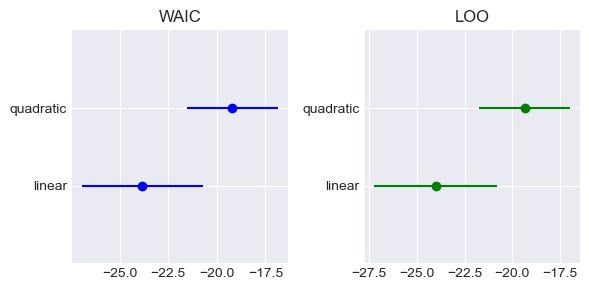

In [10]:
# 単回帰モデルと２自他公式モデルのWAIC, LOOを表示
plt.figure(figsize=(6,3))
plt.subplot(121)
for idx, ic in enumerate((waic_l, waic_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt="bo")
plt.title("WAIC")
plt.yticks([0, 1], ["linear", "quadratic"])
plt.ylim(-1, 2)

plt.subplot(122)
for idx, ic in enumerate((loo_l, loo_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt="go")
plt.title("LOO")
plt.yticks([0, 1], ["linear", "quadratic"])
plt.ylim(-1, 2)

plt.tight_layout()
plt.savefig("img606.png")

count=160


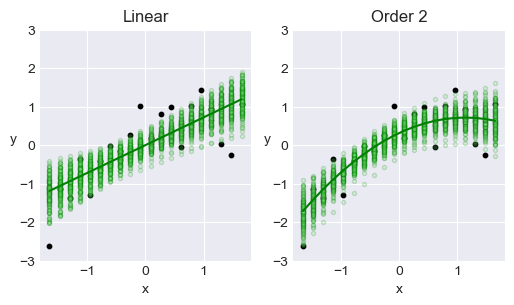

In [11]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c="k", s=10)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.title("Linear")
count = 0
for i in range(0, len(chain_l["alpha"]), 50):
    count += 1
    plt.scatter(x_1s[0], chain_l["alpha"][i] + chain_l["beta"][i]*x_1s[0],
                c="lightgreen",
                edgecolors="g",
                alpha=0.2,
                s=8)
plt.plot(x_1s[0], chain_l["alpha"].mean() + chain_l["beta"].mean()*x_1s[0],
            c="g",
            alpha=1)

print(f"{count=}")

plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c="k", s=10)
plt.ylim(-3, 3)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.title(f"Order {order}")
for i in range(0, len(chain_l["alpha"]), 50):
    plt.scatter(x_1s[0], trace_p["alpha"][i] + np.dot(trace_p["beta"][i], x_1s),
                c="lightgreen",
                edgecolors="g",
                alpha=0.2,
                s=8)
idx = np.argsort(x_1)
plt.plot(x_1s[0], alpha_p_post + np.dot(betas_p_post, x_1s),
         c="g",
         alpha=1)
plt.savefig("img607.png")


In [12]:
len(chain_l["alpha"])

8000

# ベイズファクター
## 6.4.2 ベイズファクターの計算
- 階層モデルとして定式化できる

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [theta]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bo

Sampling 4 chains for 500 tune and 5_000 draw iterations (2_000 + 20_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8840241678890343, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


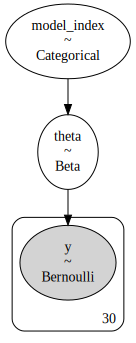

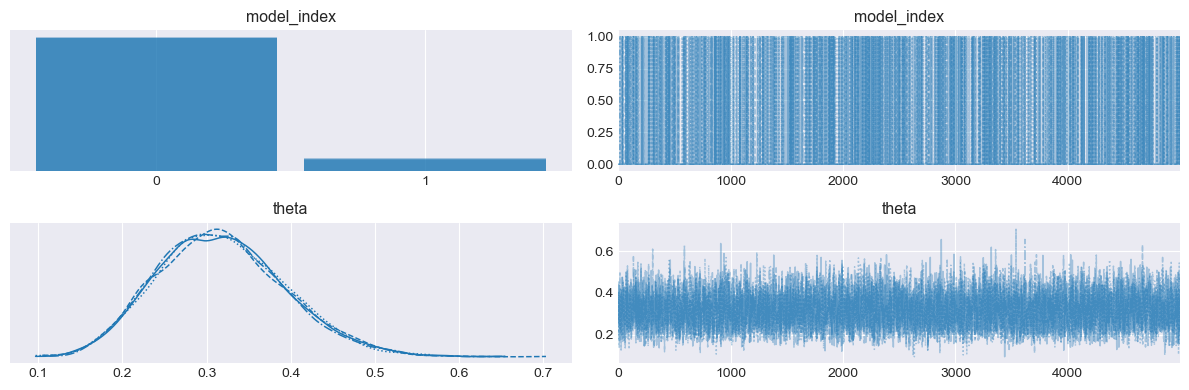

In [13]:
# ベイズファクターを例示するためのモデル出力
coins = 30
heads = 9
y_d = np.repeat([0, 1], [coins-heads, heads])

with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical("model_index", p=p)
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

    # a priori
    theta = pm.Beta("theta", m[0], m[1])
    # likelihood
    y = pm.Bernoulli("y", theta, observed=y_d)
    trace_BF = pm.sample(5000, tune=500, 
                         return_inferencedata=False)

az.plot_trace(trace_BF)
# pm.traceplot(trace_BF)
plt.tight_layout()
plt.savefig("img609.png")


pm.model_to_graphviz(model_BF)

In [14]:
pM1 = trace_BF["model_index"].mean()
pM0 = 1 - pM1
BF = (pM0/pM1)*(p[1]/p[0])
print(f"{pM0 = },\n{pM1 = },\n{BF = }")

pM0 = 0.9184,
pM1 = 0.0816,
BF = 11.254901960784313


↑ BFを見る限り、モデル0の方がモデル1より望ましいという結果に。

## 6.5 ベイズファクターと情報量規準
- ベイズファクターは事前分布に対して敏感であった
→ 推論を行う場合には事前分布はある程度中なんだが、ベイズファクターの計算にはかなり重要。**よってベイズファクターはあまり好まれない。**
- ベイズファクターが何をしているのかを見る。
    * 300回のコイン投げで90回は表が出たものとする。（さっきの例の10倍のデータ量になった）

Initializing SMC sampler...
Sampling 5 chains in 5 jobs
Stage:   0 Beta: 0.253
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.240
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.230
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.241
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.251
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 5 chains in 5 jobs
Stage:   0 Beta: 0.021
Stage:   1 Beta: 0.069
Stage:   2 Beta: 0.210
Stage:   3 Beta: 0.848
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.020
Stage:   1 Beta: 0.067
Stage:   2 Beta: 0.205
Stage:   3 Beta: 0.846
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.021
Stage:   1 Beta: 0.069
Stage:   2 Beta: 0.211
Stage:   3 Beta: 0.848
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.021
Stage:   1 Beta: 0.067
Stage:   2 Beta: 0.204
Stage:   3 Beta: 0.820
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.020
Stage:   1 Beta: 0.067
Stage:   2 Beta: 0.202
Stage:   3 Beta: 0.797
Stage:   4 Beta: 1.000
Got error No model on context stack. trying to find log_likelihood in translation.


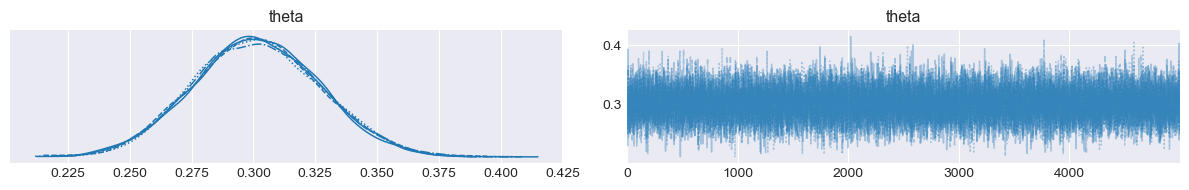

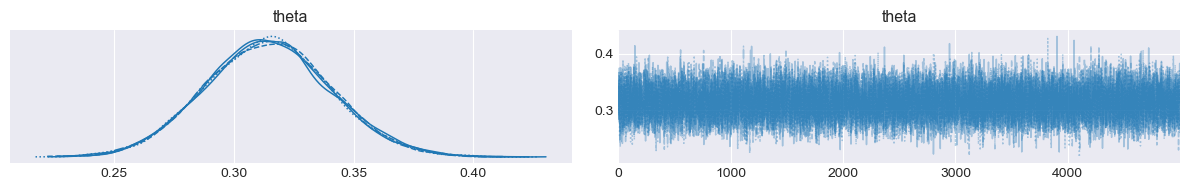

In [15]:
# ベイズファクターを例示するためのモデル出力
coins = 300
heads = 90
y_d = np.repeat([0, 1], [coins-heads, heads])

with pm.Model() as model_BF_0:
    theta = pm.Beta("theta", 4, 8)
    y = pm.Bernoulli("y", p=theta, observed=y_d)
    # trace_BF_0 = pm.sample(5000, tune=500, 
    #                        return_inferencedata=False)
    trace_BF_0 = pm.sample_smc(5000)

with pm.Model() as model_BF_1:
    theta = pm.Beta("theta", 8, 4)
    y = pm.Bernoulli("y", p=theta, observed=y_d)
    # trace_BF_1 = pm.sample(5000, tune=500, 
    #                        return_inferencedata=False)
    trace_BF_1 = pm.sample_smc(5000)

az.plot_trace(trace_BF_0)
plt.tight_layout()
plt.savefig("img610.png")
    
az.plot_trace(trace_BF_1)
plt.tight_layout()
plt.savefig("img611.png")

↑ model_BF_0, model_BF_1 どちらも同じような推論結果になっている。事前分布は違うのに！これは事前分布の効果が薄くなるほどのデータ量があるから。（少ないと推論結果も違う傾向になる）

In [16]:
# pM1 = trace_BF["model_index"].mean()
# pM0 = 1 - pM1
# BF = (pM0/pM1)*(p[1]/p[0])
# print(f"{pM0 = },\n{pM1 = },\n{BF = }")
BF_smc = np.exp(trace_BF_0.report.log_marginal_likelihood - trace_BF_1.report.log_marginal_likelihood).mean()
print(f"{BF_smc= }")

BF_smc= 25.84731083771114


In [17]:
idatas = []
waics = []
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            idata = pm.sample(2000, return_inferencedata=True)
            idatas.append(idata)
            waics.append(az.waic(idata, scale="deviance"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8803534467930981, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: R

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.879642699060578, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: Ru

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.8801270236816487, but should be close to 0.8. Try to increase the number of tuning steps.


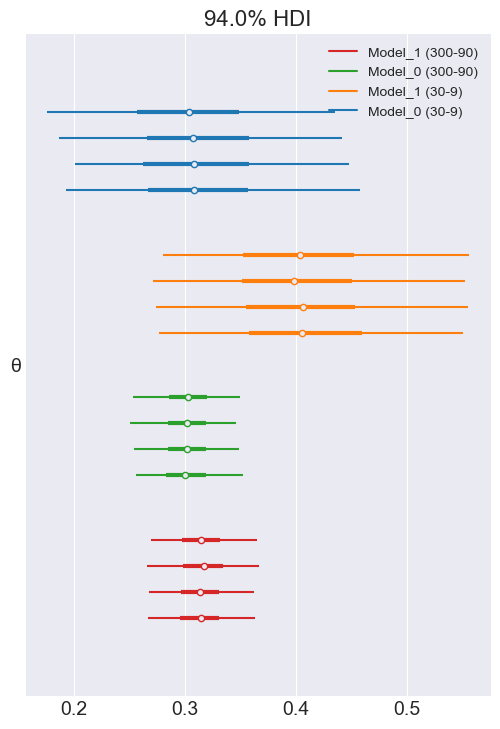

In [18]:
model_names = ['Model_0 (30-9)', 'Model_1 (30-9)',
               'Model_0 (300-90)', 'Model_1 (300-90)']

az.plot_forest(idatas, model_names=model_names)
plt.savefig('img612.png', dpi=300)

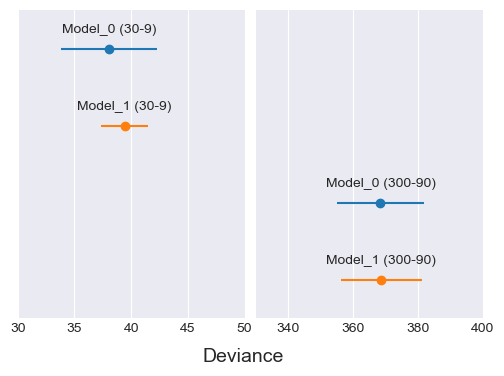

In [19]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6,4))

labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center')

ax[0].set_xlim(30, 50)
ax[1].set_xlim(330, 400)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])
plt.subplots_adjust(wspace=0.05)
fig.text(0.5, 0, 'Deviance', ha='center', fontsize=14)
plt.savefig('B11197_05_13.png', dpi=300)